## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%matplotlib inline

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SBBSSBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
487
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|               res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|8406.861268207338| 595.8026736315298| -2091.94432296576|   2072.0|SBBSSBSB| 43.8567|-110.5889|       SNWD|0.11229294319897737| 0.10783425804107764|0.052867242901368176|0.62769277

In [6]:
#extract longitude and latitude for each station
feature1='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature1
print(Query)
df_coeff1 = sqlContext.sql(Query)
df_coeff1.show(4)


SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-----------------+
|    station|latitude|longitude|elevation|          coeff_1|
+-----------+--------+---------+---------+-----------------+
|USC00486440| 43.8567|-110.5889|   2072.0|8406.861268207338|
|USC00480140| 43.7728|-111.0339|   1962.0|6696.111158449579|
|USC00486440| 43.8567|-110.5889|   2072.0|7113.387274922035|
|USC00486428| 43.6536|-110.7169|   1964.1|4990.566904161849|
+-----------+--------+---------+---------+-----------------+
only showing top 4 rows



In [7]:
df2_coeff1=df_coeff1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature1: "mean"})
pdf_coeff1=df2_coeff1.toPandas()
pdf_coeff1.sort_values(by=['station'],inplace=True)

mlat = round(pdf_coeff1.latitude.min(),4)
mxlat = round(pdf_coeff1.latitude.max(),4)
mlong = round(pdf_coeff1.longitude.min(),4)
mxlong = round(pdf_coeff1.longitude.max(),4)
pdf_coeff1.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
0,US1WYTT0009,43.6215,-110.6253,2030.9,1,1633.779769
19,USC00480140,43.7728,-111.0339,1962.0,59,3205.087986


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature1
_min=pdf_coeff1[_avg].min()
_max=pdf_coeff1[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0058ff'

## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (mlat, mxlat, mlong, mxlong)


In [10]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 7

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf_coeff1.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m  


Widget Javascript not detected.  It may not be installed or enabled properly.


In [11]:
#extract longitude and latitude for each station
feature2='coeff_2'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature2
print(Query)
df_coeff2 = sqlContext.sql(Query)
df_coeff2.show(4)

SELECT station, latitude,longitude,elevation,coeff_2 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_2|
+-----------+--------+---------+---------+------------------+
|USC00486440| 43.8567|-110.5889|   2072.0| 595.8026736315298|
|USC00480140| 43.7728|-111.0339|   1962.0|1317.3940997841037|
|USC00486440| 43.8567|-110.5889|   2072.0|1162.8834670460706|
|USC00486428| 43.6536|-110.7169|   1964.1|-230.7785627653895|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [12]:
df2_coeff2=df_coeff2.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature2: "mean"})
pdf_coeff2=df2_coeff2.toPandas()
pdf_coeff2.sort_values(by=['station'],inplace=True)

mlat2 = round(pdf_coeff2.latitude.min(),4)
mxlat2 = round(pdf_coeff2.latitude.max(),4)
mlong2 = round(pdf_coeff2.longitude.min(),4)
mxlong2 = round(pdf_coeff2.longitude.max(),4)
pdf_coeff2.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_2)
0,US1WYTT0009,43.6215,-110.6253,2030.9,1,-591.438450
19,USC00480140,43.7728,-111.0339,1962.0,59,-59.545602


In [13]:
_avg2='avg(%s)'%feature2
_min2=pdf_coeff2[_avg2].min()
_max2=pdf_coeff2[_avg2].max()
_min2,_max2


min_lat2,max_lat2,min_long2,max_long2 = box = (mlat2, mxlat2, mlong2, mxlong2)
lat_margin=(max_lat2-min_lat2)/4
long_margin=(max_long2-min_long2)/4
circles = []
for index,row in pdf_coeff2.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef2=row[_avg2]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c2 = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#FF0', opacity=0.2, fill_opacity=0.2,
            fill_color=get_color(_coef2))
    circles.append(c2)
    m.add_layer(c2)
m  


Widget Javascript not detected.  It may not be installed or enabled properly.


In [14]:
#extract longitude and latitude for each station
feature3='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature3
print(Query)
df_coeff3 = sqlContext.sql(Query)
df_coeff3.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_3|
+-----------+--------+---------+---------+------------------+
|USC00486440| 43.8567|-110.5889|   2072.0| -2091.94432296576|
|USC00480140| 43.7728|-111.0339|   1962.0|344.66029613174214|
|USC00486440| 43.8567|-110.5889|   2072.0|-2071.509117299705|
|USC00486428| 43.6536|-110.7169|   1964.1| 294.7438443945501|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [15]:
df2_coeff3=df_coeff3.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature3: "mean"})
pdf_coeff3=df2_coeff3.toPandas()
pdf_coeff3.sort_values(by=['station'],inplace=True)

mlat3 = round(pdf_coeff3.latitude.min(),4)
mxlat3 = round(pdf_coeff3.latitude.max(),4)
mlong3 = round(pdf_coeff3.longitude.min(),4)
mxlong3 = round(pdf_coeff3.longitude.max(),4)
pdf_coeff3.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
0,US1WYTT0009,43.6215,-110.6253,2030.9,1,1706.224067
19,USC00480140,43.7728,-111.0339,1962.0,59,230.033858


In [16]:
_avg3='avg(%s)'%feature3
_min3=pdf_coeff3[_avg3].min()
_max3=pdf_coeff3[_avg3].max()
_min3,_max3


min_lat3,max_lat3,min_long3,max_long3 = box = (mlat3, mxlat3, mlong3, mxlong3)
lat_margin=(max_lat3-min_lat3)/4
long_margin=(max_long3-min_long3)/4
circles = []
for index,row in pdf_coeff3.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef3=row[_avg3]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c3 = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#000', opacity=0.1, fill_opacity=0.1,
            fill_color=get_color(_coef3))
    circles.append(c3)
    m.add_layer(c3)
m  


Widget Javascript not detected.  It may not be installed or enabled properly.


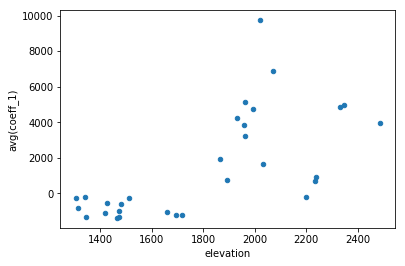

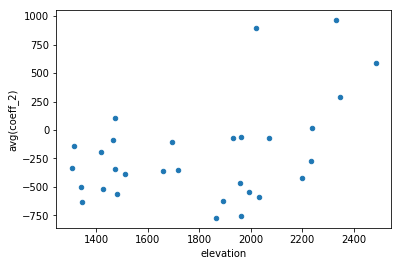

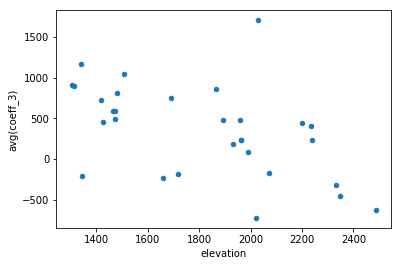

In [17]:
pdf_coeff1.plot.scatter(x='elevation',y='avg(coeff_1)')
pdf_coeff2.plot.scatter(x='elevation',y='avg(coeff_2)')
pdf_coeff3.plot.scatter(x='elevation',y='avg(coeff_3)');